In [ ]:
# Install the required libraries in your Google Colab environment
!pip install gymnasium mujoco stable-baselines3 ollama -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import the necessary libraries
import gymnasium as gym
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import ollama
import matplotlib.animation as animation
import re
import json
import seaborn as sns

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.interpolate import interp1d
from tqdm import tqdm
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from google.colab import data_table
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataframe back from the pickle file
trajectory_df = pd.read_pickle('/content/drive/MyDrive/05_zero_shot_llm_3/03_reacher_data/02_trajectories/1_human_feedback/2_Hf_D_Aggressive_Reacher_df_1.pkl')   # Update directory location 1

In [ ]:
# Display the data frame
data_table.enable_dataframe_formatter()
data_table.DataTable(trajectory_df)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Check the data type of each column
print(type(trajectory_df['Episode'][0]))
print(type(trajectory_df['Timestep'][0]))
print(type(trajectory_df['State'][0]))
print(type(trajectory_df['Action'][0]))
print(type(trajectory_df['Reward'][0]))
print(type(trajectory_df['Next State'][0]))

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>
<class 'numpy.ndarray'>


In [ ]:
def apply_pca(trajectory_df):
    """
    Apply PCA to reduce trajectory features to 7 principal components.
    Print variance explained and cumulative variance for the 7 components.
    """

    # Extract numerical values from state and action
    state_columns = [f"state_{i}" for i in range(len(trajectory_df["State"].iloc[0]))]
    action_columns = [f"action_{i}" for i in range(len(trajectory_df["Action"].iloc[0]))]

    # Expand state and action columns
    state_values = np.vstack(trajectory_df["State"].values)
    action_values = np.vstack(trajectory_df["Action"].values)

    # Create a new DataFrame with extracted features
    feature_df = pd.DataFrame(state_values, columns=state_columns)
    action_df = pd.DataFrame(action_values, columns=action_columns)

    # Concatenate extracted values with reward
    #feature_df = pd.concat([feature_df, action_df, trajectory_df["Reward"].reset_index(drop=True)], axis=1)
    # Concatenate extracted values with reward-related features
    features = ["Reward", "Distance Reward", "Smoothness Reward", "Effort Reward", "Smoothness Weighted Reward", "Effort Weighted Reward", "Recalibrated Reward"]
    feature_df = pd.concat([feature_df, action_df, trajectory_df[features].reset_index(drop=True)], axis=1)


    # Handle missing values (if any)
    feature_df.fillna(0, inplace=True)

    # Standardize the data (always important for PCA!)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(feature_df)

    # Apply PCA with 3 components
    pca = PCA(n_components=7)
    pca_features = pca.fit_transform(X_scaled)

    pc_loadings = pd.DataFrame(
    pca.components_[:7],  # First 7 principal components
    columns=feature_df.columns,
    index=[f'PC{i}' for i in range(1, 8)])

    print(pc_loadings)
    print("Explained variance ratio:", pca.explained_variance_ratio_[:7])

    # Create output dataframe with PCs
    trajectory_df_pca = trajectory_df.copy()
    trajectory_df_pca["PC1"] = pca_features[:, 0]
    trajectory_df_pca["PC2"] = pca_features[:, 1]
    trajectory_df_pca["PC3"] = pca_features[:, 2]
    trajectory_df_pca["PC4"] = pca_features[:, 3]
    trajectory_df_pca["PC5"] = pca_features[:, 4]
    trajectory_df_pca["PC6"] = pca_features[:, 5]
    trajectory_df_pca["PC7"] = pca_features[:, 6]

    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()

    # Print variance info
    for i in range(7):
        print(f"PC{i+1} explains {explained_variance[i]*100:.2f}% variance.")

    print(f"Cumulative variance explained by 7 PCs: {cumulative_variance[-1]*100:.2f}%")

    return trajectory_df_pca, pca

In [ ]:
def find_optimal_clusters(data, max_clusters=30):
    """
    Determine the optimal number of clusters using Calinski-Harabasz Index.
    Also prints Silhouette and Davies-Bouldin scores for comparison.
    """
    best_ch_score = -1
    best_k = 2

    print("\nEvaluating clustering metrics:\n")

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)

        # Compute metrics
        silhouette_avg = silhouette_score(data, cluster_labels)
        dbi = davies_bouldin_score(data, cluster_labels)
        ch = calinski_harabasz_score(data, cluster_labels)

        print(f"\nFor k = {k}:")
        print(f"   Silhouette Score       = {silhouette_avg:.4f}")
        print(f"   Davies-Bouldin Index   = {dbi:.4f}")
        print(f"   Calinski-Harabasz Index= {ch:.2f}")

        # Compute per-cluster silhouette scores
        sample_silhouette_values = silhouette_samples(data, cluster_labels)
        for cluster in range(k):
            cluster_silhouette = sample_silhouette_values[cluster_labels == cluster]
            cluster_mean_silhouette = np.mean(cluster_silhouette)
            print(f"     Cluster {cluster}: mean silhouette = {cluster_mean_silhouette:.4f}")

        # Select best k using highest Calinski-Harabasz Index
        if ch > best_ch_score:
            best_ch_score = ch
            best_k = k

    print(f"\n Optimal number of clusters selected: {best_k} (based on highest Calinski-Harabasz index = {best_ch_score:.2f})")
    return best_k

In [ ]:
def apply_clustering(trajectory_df_pca):
    """
    Apply KMeans clustering to select representative timesteps for LLM evaluation.
    Uses PC1–PC3 by default.
    """
    features = ["PC1", "PC2", "PC3","PC4","PC5","PC6","PC7"]
    X = trajectory_df_pca[features]

    # Find optimal number of clusters using all three metrics
    optimal_clusters = find_optimal_clusters(X)

    # Apply KMeans with best k
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
    trajectory_df_pca["Cluster"] = kmeans.fit_predict(X)

    # Select one representative per cluster
    cluster_representatives = trajectory_df_pca.groupby("Cluster").first().reset_index()

    return trajectory_df_pca, cluster_representatives, kmeans

In [ ]:
def visualize_7_pca_components(trajectory_df_pca):
    """
    Visualize the first 7 principal components using pairwise scatterplots, colored by cluster.
    """
    # Select the first 7 PCs and the cluster column
    pc_columns = [f"PC{i}" for i in range(1, 8)]
    plot_df = trajectory_df_pca[pc_columns + ["Cluster"]].copy()
    plot_df["Cluster"] = plot_df["Cluster"].astype(str)  # For coloring

    # Create pairplot
    sns.pairplot(
        plot_df,
        vars=pc_columns,
        hue="Cluster",
        palette="viridis",
        diag_kind="kde",
        corner=True  # To avoid redundant upper triangle
    )
    plt.suptitle("Pairwise Scatter Plots of First 7 Principal Components", y=1.02)
    plt.show()

In [ ]:
trajectory_df_pca, pca = apply_pca(trajectory_df)
print(pca)

      state_0   state_1   state_2   state_3   state_4   state_5   state_6  \
PC1 -0.162662 -0.127477 -0.066712 -0.103068  0.151002 -0.074237 -0.122310   
PC2 -0.149541 -0.296353  0.442075  0.429671 -0.152166  0.361808  0.201433   
PC3  0.431083  0.388919 -0.088960  0.084375  0.456431 -0.150800  0.021920   
PC4  0.314752  0.119689  0.100615  0.100181  0.428742  0.362453  0.253623   
PC5 -0.145998  0.060036 -0.290197 -0.257914 -0.139711 -0.194079  0.426862   
PC6  0.259523  0.120965  0.121210  0.065873 -0.039682  0.270375 -0.116200   
PC7 -0.006903  0.075887 -0.028652 -0.230322 -0.040553  0.158990  0.638701   

      state_7   state_8   state_9  action_0  action_1    Reward  \
PC1 -0.158562 -0.312897 -0.126082 -0.038552 -0.177065  0.365398   
PC2  0.379060 -0.124481  0.192858 -0.146050  0.011726  0.069878   
PC3  0.207567 -0.055388  0.402824 -0.309734 -0.111906  0.043148   
PC4  0.062021 -0.201549 -0.306698  0.359551  0.300311  0.071377   
PC5  0.235063  0.045995 -0.026835  0.283320  0.4

In [ ]:
trajectory_df_pca, cluster_representatives, kmeans = apply_clustering(trajectory_df_pca)


Evaluating clustering metrics:


For k = 2:
   Silhouette Score       = 0.3591
   Davies-Bouldin Index   = 1.3667
   Calinski-Harabasz Index= 2013.56
     Cluster 0: mean silhouette = 0.4090
     Cluster 1: mean silhouette = 0.1802

For k = 3:
   Silhouette Score       = 0.3076
   Davies-Bouldin Index   = 1.2460
   Calinski-Harabasz Index= 2168.31
     Cluster 0: mean silhouette = 0.3169
     Cluster 1: mean silhouette = 0.3570
     Cluster 2: mean silhouette = 0.1749

For k = 4:
   Silhouette Score       = 0.3043
   Davies-Bouldin Index   = 1.2344
   Calinski-Harabasz Index= 1968.87
     Cluster 0: mean silhouette = 0.1596
     Cluster 1: mean silhouette = 0.3192
     Cluster 2: mean silhouette = 0.2324
     Cluster 3: mean silhouette = 0.3808

For k = 5:
   Silhouette Score       = 0.3243
   Davies-Bouldin Index   = 1.1470
   Calinski-Harabasz Index= 1919.21
     Cluster 0: mean silhouette = 0.2230
     Cluster 1: mean silhouette = 0.3511
     Cluster 2: mean silhouette = 0.2980
   

In [ ]:
data_table.enable_dataframe_formatter()
data_table.DataTable(trajectory_df_pca)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(cluster_representatives)
print(kmeans)

   Cluster  Episode  Timestep  \
0        0        1        11   
1        1        1         0   
2        2        2         0   

                                               State  \
0  [0.9821804099329651, 0.9795227859116845, 0.187...   
1  [0.9966714523745062, 0.9994154655366121, -0.08...   
2  [0.9995621851446879, 0.9984729745410151, 0.029...   

                      Action    Reward  \
0  [0.050941303, 0.11093265] -0.069928   
1  [0.10572705, 0.013632492] -0.106170   
2   [0.29882652, 0.14123796] -0.367570   

                                          Next State  Distance Reward  \
0  [0.9758758274324504, 0.9655217868993612, 0.218...        -0.055956   
1  [0.9970110853031734, 0.9994319231147754, -0.07...        -0.095443   
2  [0.999141774261716, 0.9987712083330149, 0.0414...        -0.259370   

   Smoothness Reward  Effort Reward  Smoothness Weighted Reward  \
0          -3.195461      -0.122070                   -0.055956   
1          -0.004987      -0.106602           

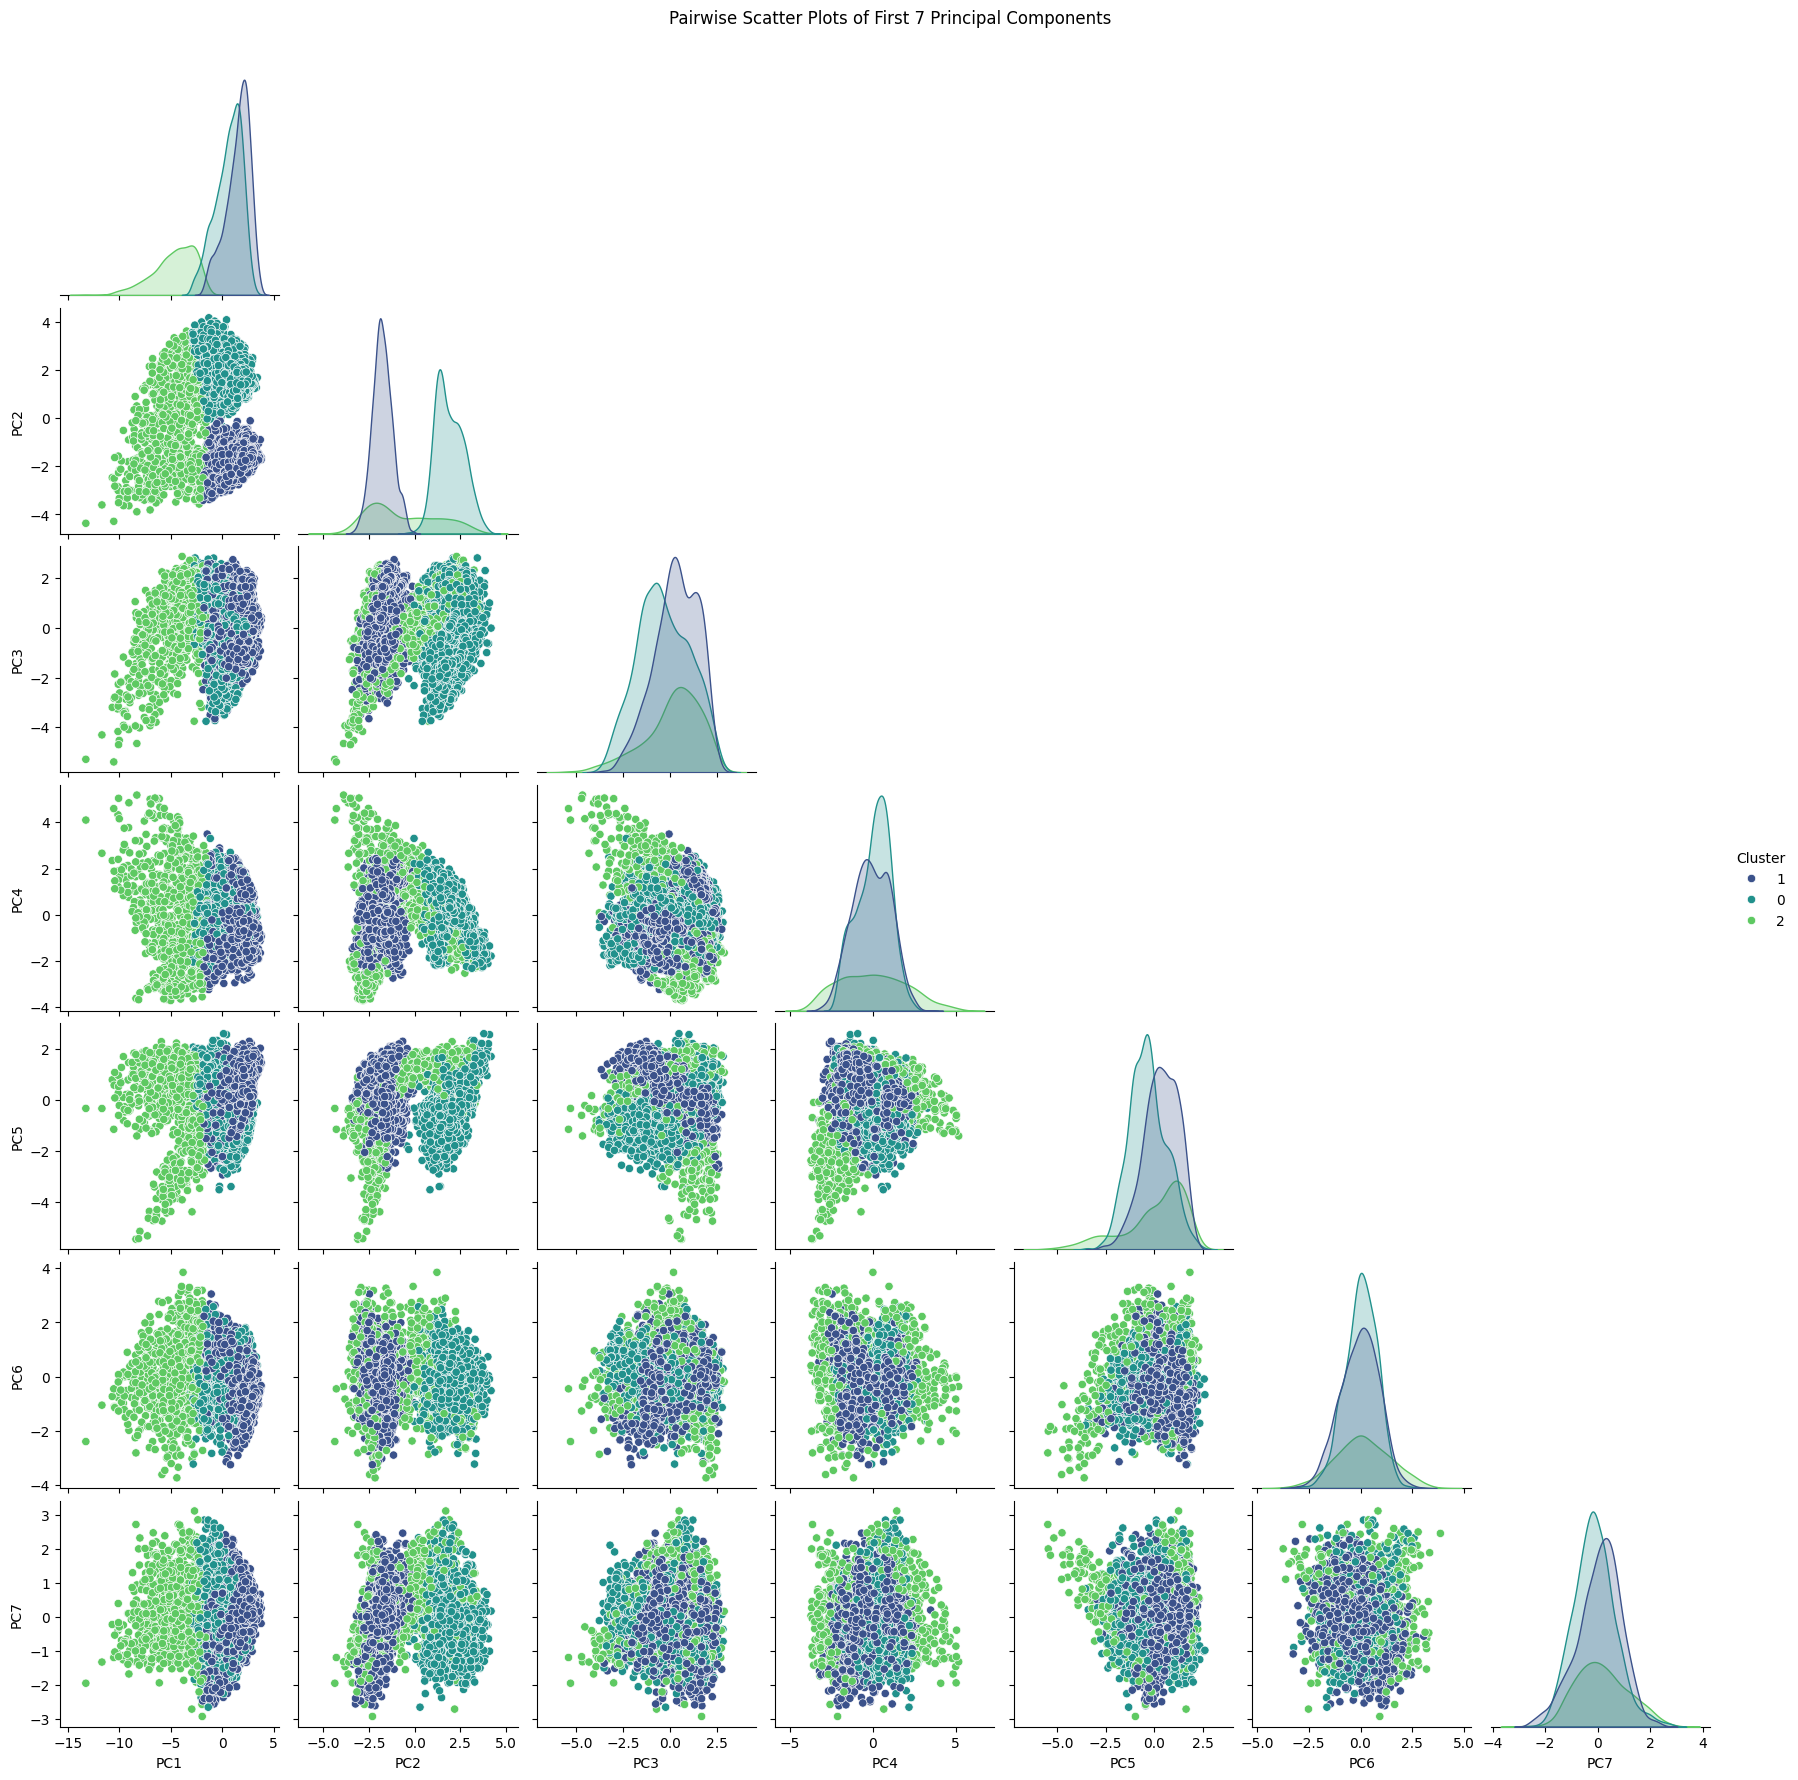

In [ ]:
visualize_7_pca_components(trajectory_df_pca)

B: LLM FEEDBACK IMPLEMENTATION <br>
SECTION B.0: LOADING THE LLM
*   Step B.0.1: Install Required Libraries
*   Step B.0.2: Setting the environment varaible  
*   Step B.0.3: Setup and Load the Pretrained LLM

In [ ]:
!pip install colab-xterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 10.7 MB/s eta 0:00:00


In [ ]:
%load_ext colabxterm

In [ ]:
%xterm
# curl -fsSL https://ollama.com/install.sh | sh
# ollama serve & ollama pull mistral
# ollama list
# ollama show mistral llama3.2

Launching Xterm...

<IPython.core.display.Javascript object>

In [ ]:
def visualize_feedback_progress(progress):
    fig, ax = plt.subplots()
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Progress (%)")
    ax.set_ylabel("Completion")

    def update(frame):
        ax.clear()
        ax.barh(["LLM Feedback"], [frame], color='blue')
        ax.set_xlim(0, 100)
        ax.set_title("Live LLM Feedback Collection Progress")

    ani = animation.FuncAnimation(fig, update, frames=progress, repeat=False)
    plt.show()

In [ ]:
def get_llm_feedback(State, Action, Reward, Next_State, Episode, Timestep, Distance_Reward, Smoothness_Reward, Effort_Reward, Smoothness_Weighted_Reward, Effort_Weighted_Reward, Recalibrated_Reward, PC1, PC2, PC3, PC4, PC5, PC6, PC7):
    """
    Function to get LLM feedback on whether the recalibrated reward is correct or biased.
    """
    prompt = f"""
    You are an expert in reinforcement learning and robotic control environments.
    You will analyze agent trajectories from the Reacher-v5 environment and assess whether the recalibrated reward
    accurately reflects the agent's performance in reaching and stabilizing the target.

    Data details:
      Episode: {Episode}
      Time Step: {Timestep}
      State: {State}
      Action: {Action}
      Reward: {Reward}
      Next State: {Next_State}
      Distance Reward: {Distance_Reward}
      Smoothness Reward: {Smoothness_Reward}
      Effort Reward: {Effort_Reward}
      Smoothness Weighted Reward: {Smoothness_Weighted_Reward}
      Effort Weighted Reward: {Effort_Weighted_Reward}
      Recalibrated Reward: {Recalibrated_Reward}
      PC1: {PC1}: PC1: Main variation in joint angles, velocities, and fingertip position linked to overall reach success.
      PC2: {PC2}: Combination of joint angles and fingertip positions associated with strong actions and lower rewards.
      PC3: {PC3}: Contrast between specific joint configurations and action strengths during movement adjustments.
      PC4: {PC4}: Large corrective actions applied when the fingertip is far from the target.
      PC5: {PC5}: Balancing fingertip position and action magnitude for reach accuracy.
      PC6: {PC6}: Fine-tuning joint velocity and fingertip position against strong actions.
      PC7: {PC7}: Alternating torque commands to joints for subtle target corrections.

    Instructions:
      Respond ONLY with a JSON object in the following format:
            {{
              "verdict": "<Correct score allotted OR Biased score allotted>",
              "justification": "<brief explanation of your decision>",
              "llm_score": <numeric score: same as adjusted_score or suggested corrected value>
            }}

      Make sure your output is strictly valid JSON. Do not include any explanation outside the JSON.
            """

    answer = ollama.generate(model="mistral", prompt=prompt, options={"temperature": 1.5, "seed": 1})
    response_text = answer['response'].strip()

    # Extract only the JSON part from the response
    json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
    if json_match:
        json_string = json_match.group(0)
        # Attempt to clean up the JSON string
        json_string = json_string.replace(',}', '}') # Remove trailing commas before closing brace
        json_string = json_string.replace(',]', ']') # Remove trailing commas before closing bracket
        try:
            feedback = json.loads(json_string)
        except json.JSONDecodeError:
            print(f"Warning: Could not parse LLM response as JSON after cleanup: {json_string}")
            feedback = None
    else:
        print(f"Warning: No JSON object found in LLM response: {response_text}")
        feedback = None


    return feedback

In [ ]:
def collect_llm_feedback_cluster(cluster_representatives):
    """
    Collect LLM feedback for each cluster representative assuming JSON-style response.
    Returns:
        - llm_feedback_data (dict): Cluster ID → full feedback (dict)
        - feedback_df (DataFrame): Contains Cluster ID, justification, llm_score
    """
    llm_feedback_data = {}
    feedback_records = []

    for i, (_, row) in tqdm(enumerate(cluster_representatives.iterrows()), total=len(cluster_representatives)):
        # Get LLM response (expected to return a JSON/dict-like structure)
        feedback = get_llm_feedback(
            row["State"], row["Action"], row["Reward"], row["Next State"],
            row["Episode"], row["Timestep"],row["Distance Reward"], row["Smoothness Reward"], row["Effort Reward"],
            row["Smoothness Weighted Reward"], row["Effort Weighted Reward"], row["Recalibrated Reward"],
            row["PC1"], row["PC2"], row["PC3"], row["PC4"], row["PC5"], row["PC6"], row["PC7"])

        cluster_id = row["Cluster"]
        llm_feedback_data[cluster_id] = feedback

        # Check if feedback is None before accessing it
        if feedback is None:
            print(f"LLM feedback for Cluster {cluster_id} was None. Skipping record creation for this cluster.")
            continue  # Skip to the next iteration if feedback is None

        # Extract fields from the feedback
        verdict = feedback.get("verdict", "N/A")
        justification = feedback.get("justification", "N/A")
        llm_score = feedback.get("llm_score", 0)

        # Print feedback
        print(f"\n--- Cluster {cluster_id} ---")
        print(f"Verdict: {verdict}")
        print(f"Justification: {justification}")
        print(f"LLM Score: {llm_score}")

        feedback_records.append({
            "Cluster": cluster_id,
            "Verdict": verdict,
            "Justification": justification,
            "LLM_Score": llm_score
        })

    # Convert to DataFrame
    feedback_df = pd.DataFrame(feedback_records)
    return llm_feedback_data, feedback_df

In [ ]:
llm_feedback_data, llm_feedback_df = collect_llm_feedback_cluster(cluster_representatives)

 33%|███▎      | 1/3 [00:11<00:23, 11.95s/it]


--- Cluster 0 ---
Verdict: Biased score allotted
Justification: The recalibrated reward appears to be higher than the computed reward and the smoothness-weighted reward, indicating a possible adjustment to compensate for some factors not captured by these metrics.
LLM Score: 0.35130179838674414


 67%|██████▋   | 2/3 [00:14<00:06,  6.56s/it]


--- Cluster 1 ---
Verdict: Biased score allotted
Justification: The recalibrated reward seems to contradict the intrinsic rewards (distance, smoothness, effort), and the principal component analysis suggests that a higher reward could be appropriate for this trajectory.
LLM Score: 0.75


100%|██████████| 3/3 [00:17<00:00,  5.79s/it]


--- Cluster 2 ---
Verdict: Biased score allotted
Justification: The recalibrated reward seems to contradict the original rewards and principal component analysis results, which suggest a poor performance in terms of reaching and stabilizing the target.
LLM Score: 0.1


In [ ]:
data_table.enable_dataframe_formatter()
data_table.DataTable(llm_feedback_df)

,Cluster,Verdict,Justification,LLM_Score
0,0,Biased score allotted,The recalibrated reward appears to be higher t...,0.351302
1,1,Biased score allotted,The recalibrated reward seems to contradict th...,0.750000
2,2,Biased score allotted,The recalibrated reward seems to contradict th...,0.100000


In [ ]:
llm_feedback_df.to_pickle('/content/drive/MyDrive/05_zero_shot_llm_3/03_reacher_data/02_trajectories/3_llm_hf_bf/0_llm_hf_bf_justification.pkl')     # Update directory location 2

In [ ]:
data_table.enable_dataframe_formatter()
data_table.DataTable(trajectory_df_pca)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def interpolate_llm_scores(trajectory_df_pca, llm_feedback_df):
    """
    Assigns LLM feedback scores (from llm_feedback_df) to each trajectory row using cluster mapping,
    and interpolates missing scores.
    """
    # Create mapping: Cluster ID → LLM_Score_Total
    cluster_to_score = dict(zip(llm_feedback_df["Cluster"], llm_feedback_df["LLM_Score"]))

    # Map score to each row in trajectory_df_pca
    trajectory_df_pca["LLM_Feedback_Score"] = trajectory_df_pca["Cluster"].map(cluster_to_score)

    # Interpolate missing values if any (e.g., if some clusters were missed)
    trajectory_df_pca["LLM_Feedback_Score"] = trajectory_df_pca["LLM_Feedback_Score"].interpolate()

    return trajectory_df_pca

In [ ]:
llm_score_df = interpolate_llm_scores(trajectory_df_pca, llm_feedback_df)
llm_score_df = llm_score_df.drop(['Recalibrated Reward','Distance Reward', 'Smoothness Reward', 'Effort Reward', 'Smoothness Weighted Reward', 'Effort Weighted Reward'], axis=1)

In [ ]:
data_table.enable_dataframe_formatter()
data_table.DataTable(llm_score_df)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Group the data by 'episode'
episode_data = trajectory_df_pca.groupby('Episode')
# Loop through each episode
for episode, data in episode_data:

    cluster_list = data['Cluster'].tolist()

    # Count the total number of time steps in the episode
    total_timesteps = data['Timestep'].max() + 1  # Assuming time_step starts from 0

    print(f"Episode {episode}:Total timesteps {total_timesteps}: {cluster_list}")

In [ ]:
# Group the data by 'episode'
episode_data = llm_score_df.groupby('Episode')
# Loop through each episode
for episode, data in episode_data:
    # Extract lane indices
    llm_score_list = data['LLM_Feedback_Score'].tolist()

    # Count the total number of time steps in the episode
    total_timesteps = data['Timestep'].max() + 1  # Assuming time_step starts from 0

    print(f"Episode {episode}:Total timesteps {total_timesteps}: {llm_score_list}")

Section B.2: REWARD MODELLING(LLM FEEDBACK)

*   Step B.2.1: Recalibrate Reward Based on LLM Feedback
*   Step 3.2.2: Displaying the recalibrated rewards based on LLM feedback
*   Step 3.2.3: Access the reward for a specific step

In [ ]:
# Step B.2.3: Recalibrate Reward Based on LLM Feedback
# Function to recalibrate the rewards
def recalibrate_rewards(df):
    # Create a copy of the dataframe
    df_copy = df.copy()

    # Create the 'Recalibrated_rewards' column
    df_copy['Recalibrated_rewards'] = df_copy['Reward'] + df_copy['LLM_Feedback_Score']

    # Get the list of recalibrated rewards
    recalibrated_rewards_list = df_copy['Recalibrated_rewards'].tolist()

    return df_copy, recalibrated_rewards_list

In [ ]:
# Apply the function to recalibrate rewards
recalibrated_df, recalibrated_rewards_list = recalibrate_rewards(llm_score_df)

In [ ]:
data_table.enable_dataframe_formatter()
data_table.DataTable(recalibrated_df)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
recalibrated_df.to_pickle('/content/drive/MyDrive/05_zero_shot_llm_3/03_reacher_data/02_trajectories/3_llm_hf_bf/1_llm_hd_bf_df_reacher_1.pkl')    # Update directory location 3

Execute from here if alpha is variable

In [ ]:
# To access the reward for a specific step:
for i, feedback in enumerate(recalibrated_rewards_list):
    human_recalibrated_reward_for_step = recalibrated_rewards_list[i]
    print(f"Recalibrated reward for step {i}: {human_recalibrated_reward_for_step}")

Recalibrated reward for step 0: 0.6438303304543852
Recalibrated reward for step 1: 0.6475573176120888
Recalibrated reward for step 2: 0.6390434253980224
Recalibrated reward for step 3: 0.6233368176898672
Recalibrated reward for step 4: 0.663953994045244
Recalibrated reward for step 5: 0.6683614240715079
Recalibrated reward for step 6: 0.6788758550313222
Recalibrated reward for step 7: 0.6751489234847913
Recalibrated reward for step 8: 0.6654929391403033
Recalibrated reward for step 9: 0.6727288422320857
Recalibrated reward for step 10: 0.6714642402297971
Recalibrated reward for step 11: 0.2813736569683615
Recalibrated reward for step 12: 0.2942999499382254
Recalibrated reward for step 13: 0.27260323885120485
Recalibrated reward for step 14: 0.2824893698406466
Recalibrated reward for step 15: 0.2736756305594266
Recalibrated reward for step 16: 0.27506365941872746
Recalibrated reward for step 17: 0.23801081375257205
Recalibrated reward for step 18: 0.2609368632022574
Recalibrated reward 

SECTION A.5: MODEL TRAINING(HUMAN FEEDBACK DIRECT- IDEAL CASE SCENARIO)
*   Step A.5.1: CUSTOM REWARD FUNCTION
*   Step A.5.2: LOAD THE SAVED INITIALLY TRAINED PPO MODEL FROM GOOGLE DRIVE
*   Step A.5.3: TRAIN/UPDATE PPO MODEL WITH RECALIBRATED REWARD
*   Step A.5.4: SAVE THE TRAINED MODEL(HF_IDEAL) FOR TESTING

In [ ]:
# Step A.5.1: CUSTOM REWARD FUNCTION
def custom_reward(self, env, state, action, next_state, reward, done):
    # Access and recalculate the reward using human_feedback_data or recalibrate_rewards_human function
    global step_counter
    try:
        step_counter
    except NameError:
        step_counter = 0

    reward = recalibrated_rewards_list[step_counter]
    step_counter += 1
    return reward

# Create a new environment class that wraps your original environment and overrides the default reward function with your custom function
class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super(CustomRewardWrapper, self).__init__(env)

    def step(self, action):
        next_state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        reward = custom_reward(self, self.env, self.last_obs, action, next_state, reward, done)
        # custom_reward should be defined and accessible to your class
        self.last_obs = next_state
        return next_state, reward, terminated, truncated, info

    def reset(self, **kwargs):
        global step_counter
        step_counter = 0
        self.last_obs = self.env.reset(**kwargs)[0]  # Assuming Gymnasium env returns (obs, info)
        return self.last_obs, {}  # Assuming Gymnasium env requires (obs, info)
# Create and wrap the environment with your custom reward wrapper
# env_human = CustomRewardWrapper(gym.make('highway-v0'))

PPO training and Training logs

In [ ]:
drive_log_dir = "/content/drive/MyDrive/05_zero_shot_llm_3/03_reacher_data/00_training_logs/5_log_dir/5_ppo_reacher_llm_hf_bf"    # Update directory location 4

In [ ]:
# Train PPO with Custom Rewards
def train_ppo_with_custom_rewards(log_dir=drive_log_dir, total_timesteps=200000):
    os.makedirs(log_dir, exist_ok=True)
    env = CustomRewardWrapper(gym.make("Reacher-v5"))
    env = Monitor(env, log_dir)
    model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_dir)
    model.learn(total_timesteps=total_timesteps)
    model.save('/content/drive/MyDrive/05_zero_shot_llm_3/03_reacher_data/01_trained_models/5_ppo_reacher_llm_hf_bf')     # Update directory location 5
    return model, log_dir

In [ ]:
# Execute Training and Convergence Tracking
model, log_dir = train_ppo_with_custom_rewards(total_timesteps=200000)

Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to /content/drive/MyDrive/05_zero_shot_llm_3/03_reacher_data/00_training_logs/5_log_dir/5_ppo_reacher_llm_hf_bf/PPO_1


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 15.5     |
| time/              |          |
|    fps             | 426      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | 15.5        |
| time/                   |             |
|    fps                  | 390         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004949343 |
|    clip_fraction        | 0.0233      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.85       |
|    explained_variance   | 0.00215     |
|    learning_rate        | 0.

In [ ]:
log_path = os.path.join(drive_log_dir, "monitor.csv")
df = pd.read_csv(log_path, skiprows=1)
# Ensure episodes are logged correctly
df.reset_index(inplace=True)
df.rename(columns={"index": "episode", "r": "reward", "l": "length", "t": "time_step"}, inplace=True)

In [ ]:
data_table.enable_dataframe_formatter()
data_table.DataTable(df.head())

,episode,reward,length,time_step
0,0,15.489222,50,6.715310
1,1,15.489222,50,6.790584
2,2,15.489222,50,6.864315
3,3,15.489222,50,7.008628
4,4,15.489222,50,7.089852
